In [6]:
import rasterio
from rasterio.windows import Window
import numpy as np
import matplotlib.pyplot as plt
import os

# --- Cell 1: Setup File Paths and Status ---
# Define the input and output file paths
pre_fire_path = 'data/Sigma0_VH_Pre.img'
post_fire_path = 'data/Sigma0_VH_Post.img'
log_ratio_path = 'log_ratio_full_res.tif'
burn_scar_path = 'burn_scar_map_full_res.tif'

# This flag will track if processing steps are successful
processing_successful = True

# --- Cell 2: Calculate Log-Ratio using Block Processing ---
# This cell calculates the log-ratio in chunks to avoid loading the whole image into memory.
try:
    # Check if input files exist before starting
    if not os.path.exists(pre_fire_path) or not os.path.exists(post_fire_path):
        raise FileNotFoundError(f"Input file not found. Ensure '{pre_fire_path}' and '{post_fire_path}' are in the correct directory.")

    with rasterio.open(pre_fire_path) as pre_src, rasterio.open(post_fire_path) as post_src:
        # Check if basic properties match (optional but good practice)
        if pre_src.profile['crs'] != post_src.profile['crs'] or pre_src.profile['transform'] != post_src.profile['transform']:
            print("Warning: CRS or Affine transforms do not match between images.")

        # Get the profile for the output file and update it for the log-ratio data
        profile = pre_src.profile
        profile.update(dtype=rasterio.float32, count=1, driver='GTiff')

        print("Calculating full-resolution log-ratio...")
        # Open a new file to write the results to, block by block
        with rasterio.open(log_ratio_path, 'w', **profile) as dst:
            # Iterate through the blocks (windows) of the raster
            for ji, window in pre_src.block_windows(1):
                pre_block = pre_src.read(1, window=window)
                post_block = post_src.read(1, window=window)
                epsilon = 1e-10
                log_ratio_block = np.log((post_block.astype(float) + epsilon) / (pre_block.astype(float) + epsilon))
                dst.write(log_ratio_block.astype(rasterio.float32), window=window)
    print(f"Full-resolution log-ratio calculation complete. Saved to '{log_ratio_path}'")

except (FileNotFoundError, Exception) as e:
    print(f"An error occurred in Cell 2: {e}")
    processing_successful = False

# --- Cell 3: Create, Visualize, and Analyze Log-Ratio Thumbnail ---
# This cell only runs if the previous step was successful.
if processing_successful:
    try:
        with rasterio.open(log_ratio_path) as src:
            thumbnail_size = 1024
            thumbnail = src.read(1, out_shape=(src.count, thumbnail_size, thumbnail_size), resampling=rasterio.enums.Resampling.bilinear)
            print("\nCreated a low-resolution thumbnail for visualization.")

            plt.figure(figsize=(10, 10))
            plt.imshow(thumbnail, cmap='jet', vmin=-1, vmax=1)
            plt.title('Log-Ratio Thumbnail (Low Resolution)')
            plt.colorbar(label='Log-Ratio')
            plt.show()
            
            plt.figure(figsize=(10, 6))
            plt.hist(thumbnail.flatten(), bins=100, range=(-2, 2))
            plt.title('Histogram of Log-Ratio Values (from Thumbnail)')
            plt.xlabel('Log-Ratio')
            plt.ylabel('Frequency')
            plt.grid(True)
            plt.show()
            print("\nAnalyze this histogram to determine the best threshold.")

    except Exception as e:
        print(f"An error occurred in Cell 3: {e}")
        processing_successful = False

# --- Cell 4: Apply Threshold using Block Processing ---
# This cell only runs if all previous steps were successful.
if processing_successful:
    threshold = -0.5
    print(f"Using threshold: {threshold} to create the final map.")
    try:
        with rasterio.open(log_ratio_path) as src:
            profile = src.profile
            profile.update(dtype=rasterio.uint8, count=1, driver='GTiff')

            print("Creating full-resolution burn scar map...")
            with rasterio.open(burn_scar_path, 'w', **profile) as dst:
                for ji, window in src.block_windows(1):
                    log_ratio_block = src.read(1, window=window)
                    burn_scar_block = np.where(log_ratio_block < threshold, 1, 0)
                    dst.write(burn_scar_block.astype(rasterio.uint8), window=window)
        print(f"Full-resolution burn scar map created. Saved to '{burn_scar_path}'")

    except Exception as e:
        print(f"An error occurred in Cell 4: {e}")
        processing_successful = False

# --- Cell 5: Visualize a Thumbnail of the Final Burn Scar Map ---
# This cell only runs if all previous steps were successful.
if processing_successful:
    try:
        with rasterio.open(burn_scar_path) as src:
            thumbnail_size = 1024
            burn_thumbnail = src.read(1, out_shape=(src.count, thumbnail_size, thumbnail_size), resampling=rasterio.enums.Resampling.nearest)
            print("\nCreated a low-resolution thumbnail of the final burn scar map.")
            plt.figure(figsize=(10, 10))
            plt.imshow(burn_thumbnail, cmap='hot')
            plt.title('Final Burn Scar Map Thumbnail (Low Resolution)')
            plt.colorbar(label='Burned (1) / Unburned (0)')
            plt.show()
    except Exception as e:
        print(f"An error occurred in Cell 5: {e}")


An error occurred in Cell 2: 'data/Sigma0_VH_Pre.img' not recognized as being in a supported file format.


In [14]:
from scipy import ndimage
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage.filters import threshold_otsu

# --- Configuration ---
# Load the pre-filtered files. This is a fast operation.
pre_fire_filtered_file = "data/Pre_Fire.tif"
post_fire_filtered_file = "data/Post_Fire.tif"

# --- Load Data ---
print("Loading PRE-FILTERED data...")
with rasterio.open(pre_fire_filtered_file) as src:
    pre_fire_filtered = src.read(1)
    transform = src.transform 
    crs = src.crs

with rasterio.open(post_fire_filtered_file) as src:
    post_fire_filtered = src.read(1)


print("✓ Data loaded. Ready for fast analysis.")
# Use filtered data for log-ratio
print(f"\nInitial pre-fire shape: {pre_fire_filtered.shape}")
print(f"Initial post-fire shape: {post_fire_filtered.shape}")

if pre_fire_filtered.shape != post_fire_filtered.shape:
    print("-> Shapes do not match. Cropping to minimum common dimensions...")
    
    min_rows = min(pre_fire_filtered.shape[0], post_fire_filtered.shape[0])
    min_cols = min(pre_fire_filtered.shape[1], post_fire_filtered.shape[1])
    
    pre_fire_filtered = pre_fire_filtered[:min_rows, :min_cols]
    post_fire_filtered = post_fire_filtered[:min_rows, :min_cols]
    
    print(f"✓ Images now aligned to shape: {pre_fire_filtered.shape}")
else:
    print("✓ Image shapes match.")

print("\nFinished")

Attempting to read raw binary file: data/Sigma0_VH_Pre.img

--- ERROR ---
The new dimensions still do not match the file size.
Total pixels in file: 689743400
Expected pixels from dimensions: 690217840


✓ Log-ratio calculated.
Original array shape for plotting: (21400, 32230)
Downsampled preview shape: (4280, 6446)

Displaying the downsampled log-ratio change map...


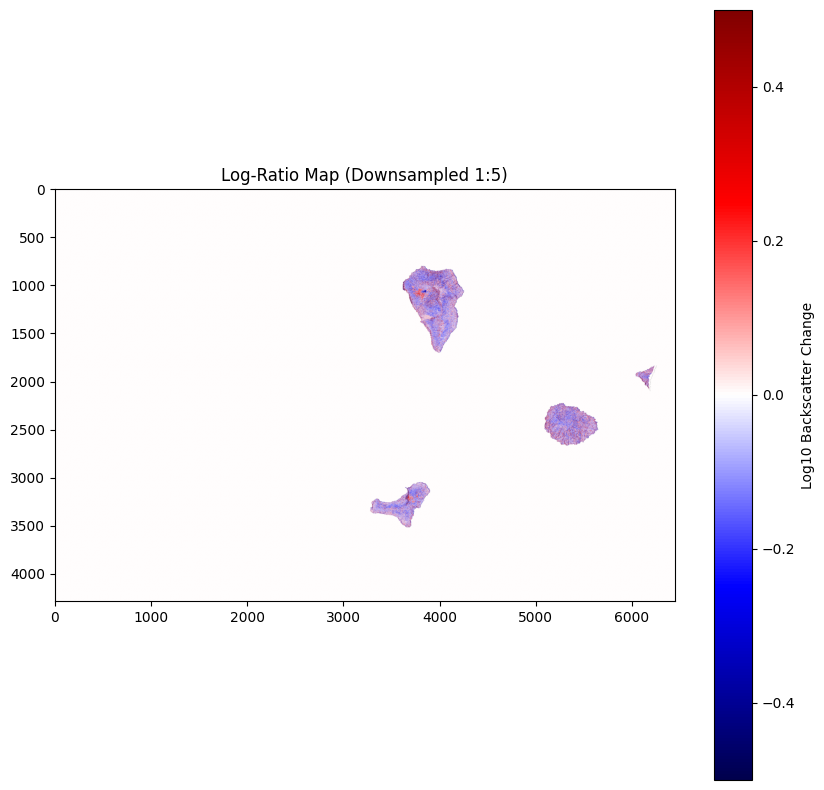

In [6]:
# --- Calculate Log-Ratio ---
# A small constant (epsilon) is added to avoid log(0) errors.
epsilon = 1e-6

# Calculate the log-ratio from the raw VH data
log_ratio = np.log10(post_fire_vh + epsilon) - np.log10(pre_fire_vh + epsilon)

print("✓ Log-ratio calculated.")

# --- Visualization (Memory Safe) ---
downsampling_factor = 5 
log_ratio_preview = log_ratio[::downsampling_factor, ::downsampling_factor]

print("\nDisplaying the downsampled log-ratio change map...")
plt.figure(figsize=(10, 10))
plt.imshow(log_ratio_preview, cmap='seismic', vmin=-0.5, vmax=0.5) 
plt.title(f"Log-Ratio Map (from .img, Downsampled 1:{downsampling_factor})")
plt.colorbar(label="Log10 Backscatter Change")
plt.show()

-> Found and removed 5200 nan values from log_ratio array.
✓ Otsu threshold automatically determined: 1.7835

Displaying the downsampled raw mask...


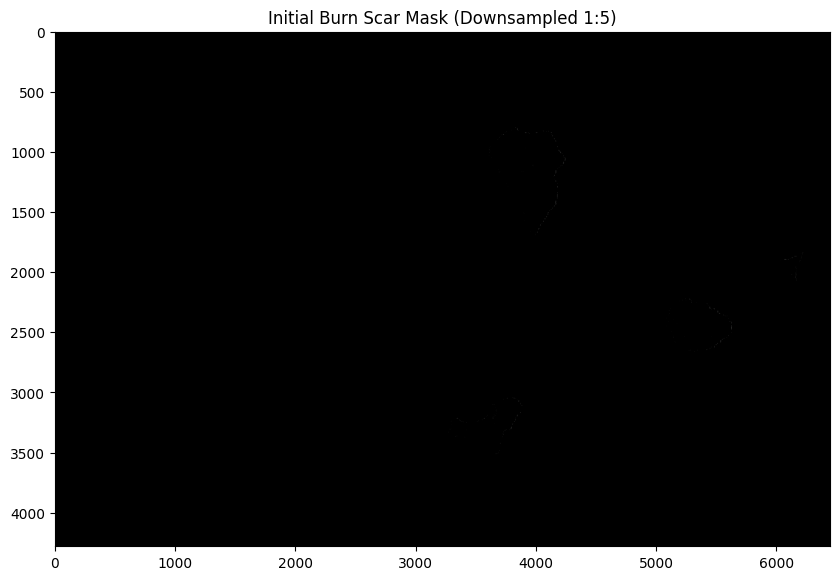

In [8]:
# --- Handle potential NaN values ---
nan_count = np.isnan(log_ratio).sum()
if nan_count > 0:
    print(f"-> Found and removed {nan_count} nan values from log_ratio array.")
    log_ratio = np.nan_to_num(log_ratio, nan=0.0)

# --- Apply Otsu's Threshold ---
otsu_threshold = threshold_otsu(-log_ratio)
burn_scar_mask = -log_ratio > otsu_threshold

print(f"✓ Otsu threshold automatically determined: {otsu_threshold:.4f}")

# --- Visualize the Raw Mask (Memory Safe) ---
burn_scar_mask_preview = burn_scar_mask[::downsampling_factor, ::downsampling_factor]

print(f"\nDisplaying the downsampled raw mask...")
plt.figure(figsize=(10, 10))
plt.imshow(burn_scar_mask_preview, cmap='gray')
plt.title(f"Initial Burn Scar Mask (Downsampled 1:{downsampling_factor})")
plt.show()

Cleaning the mask with morphological operations...
✓ Mask cleaned.

Displaying the final downsampled cleaned mask...


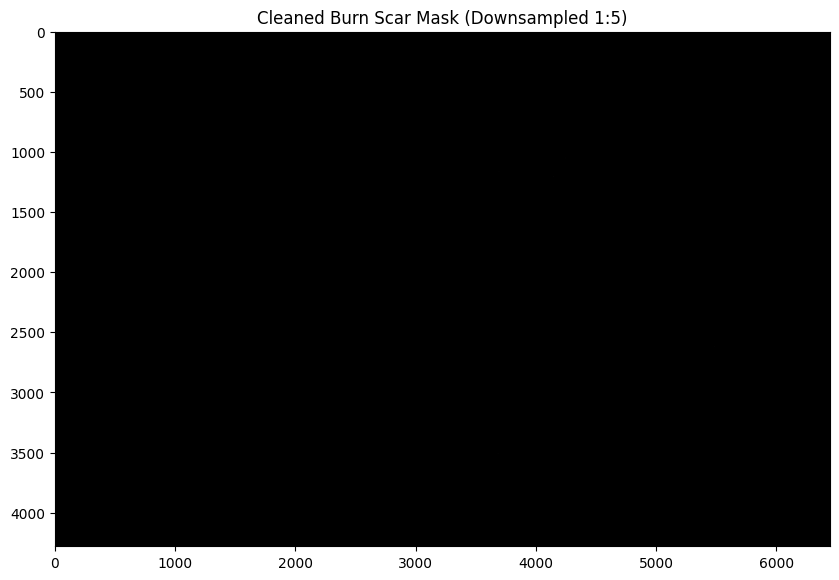

In [9]:
# --- Clean the Mask ---
structure = np.ones((3, 3), dtype=bool)

print("Cleaning the mask with morphological operations...")
closed_mask = ndimage.binary_closing(burn_scar_mask, structure=structure)
cleaned_mask = ndimage.binary_opening(closed_mask, structure=structure)

print("✓ Mask cleaned.")

# --- Visualize the Cleaned Mask (Memory Safe) ---
cleaned_mask_preview = cleaned_mask[::downsampling_factor, ::downsampling_factor]

print(f"\nDisplaying the final downsampled cleaned mask...")
plt.figure(figsize=(10, 10))
plt.imshow(cleaned_mask_preview, cmap='gray')
plt.title(f"Cleaned Burn Scar Mask (Downsampled 1:{downsampling_factor})")
plt.show()

In [13]:
# --- Calculate Area ---
pixel_width = transform.a
pixel_height = -transform.e
pixel_area_sq_m = pixel_width * pixel_height

burned_pixels_count = np.count_nonzero(cleaned_mask)

total_area_sq_m = burned_pixels_count * pixel_area_sq_m
total_area_sq_km = total_area_sq_m / 1_000_000
total_area_hectares = total_area_sq_m / 10_000

print("\n--- Burn Scar Area Calculation ---")
print(f"Total burned pixels detected: {burned_pixels_count}")
print(f"Area of one pixel: {pixel_area_sq_m:.2f} m²")
print("-" * 30)
print(f"Total Burned Area: {total_area_sq_m:,.2f} m²")
print(f"Total Burned Area: {total_area_sq_km:,.2f} km²")
print(f"Total Burned Area: {total_area_hectares:,.2f} hectares")


Fire damage detection results:
Burned pixels: 37
Burned area: 0.00 km²
Percentage of land burned: 0.00%


In [ ]:
# --- Save the Result ---
# We still save the final mask as a .tif, as it's a great format for output.
output_file = "data/Burn_Scar_Mask.tif" 

# Get the metadata from one of our original .img files
profile = rasterio.open(pre_fire_file).profile
profile.update(
    dtype=rasterio.uint8,
    count=1,
    compress='lzw'
)

print(f"\nSaving final full-resolution burn scar mask to: {output_file}")
with rasterio.open(output_file, 'w', **profile) as dst:
    dst.write(cleaned_mask.astype(rasterio.uint8), 1)

print("✓ Analysis complete. Output saved.")